In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from dowhy import gcm
from sklearn.linear_model import LinearRegression

In [2]:
# Set colours for plots
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

# Plot causal graph given adjacency matrix
def plot_graph(input_graph):
    
    graph = nx.DiGraph(input_graph)

    plt.figure(figsize=(7, 7))
    nx.draw(
    G=graph,
    node_color=COLORS[0],
    node_size=7000,
    arrowsize=17,
    with_labels=True,
    labels=node_lookup,
    font_color='white',
    font_size=9,
    pos=nx.circular_layout(graph)
    )

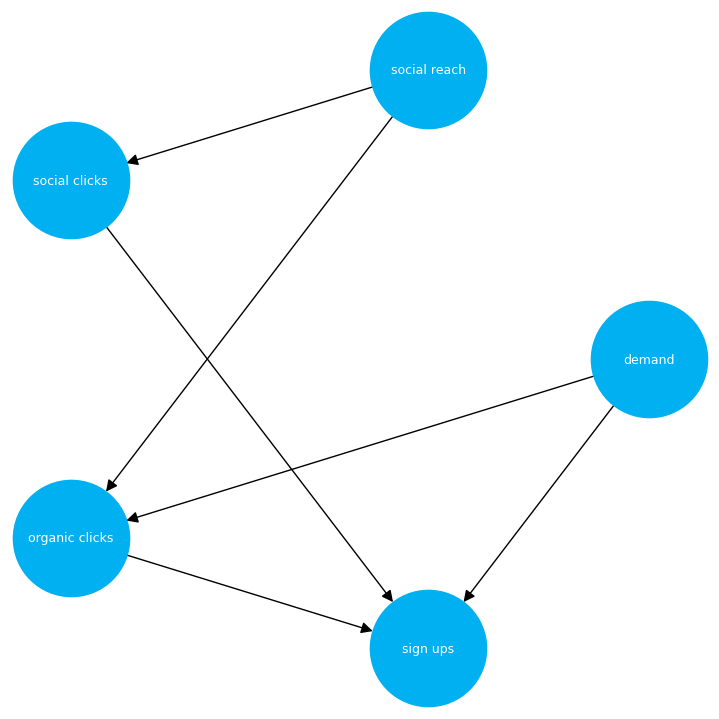

In [25]:
# Create node lookup for channels
node_lookup = {0: 'demand',
    1: 'social reach',                
    2: 'social clicks',
    3: 'organic clicks',
    4: 'sign ups'                                                                             
 }

total_nodes = len(node_lookup)

# Create adjacency matrix - this is the basis for our known graph
graph_actual = np.zeros((total_nodes, total_nodes))

# Create known graph using expert domain knowledge
graph_actual[0, 3] = 1.0 # demand -> organic clicks
graph_actual[0, 4] = 1.0 # demand -> signups

graph_actual[1, 2] = 1.0 # social reach -> social clicks
graph_actual[1, 3] = 1.0 # social reach -> organic clicks

graph_actual[2, 4] = 1.0 # social clicks -> signups
graph_actual[3, 4] = 1.0 # organic clicks -> signups

plot_graph(graph_actual)

In [26]:
# Setup graph
graph = nx.from_numpy_array(graph_actual, create_using=nx.DiGraph)
graph = nx.relabel_nodes(graph, node_lookup)

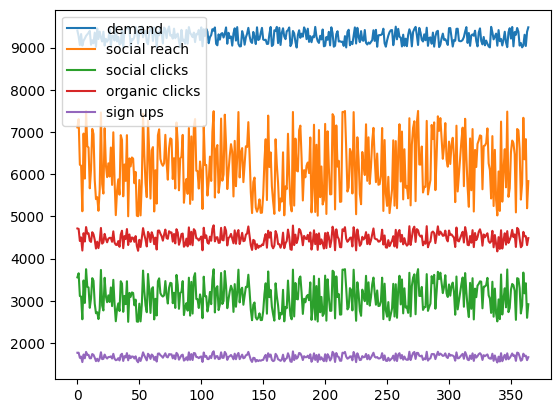

In [27]:
# Set random seed
np.random.seed(999)

# Create data behind graph (no noise included)
population = 10000
df = pd.DataFrame(columns=node_lookup.values())
df['demand'] = (population * np.random.uniform(0.90, 0.95, 365))
df['social reach'] = (population * np.random.uniform(0.50, 0.75, 365))
df['social clicks'] = (0.50 * df['social reach'])
df['organic clicks'] =  (0.35 * df['demand']) + (0.20 * df['social reach'])
df['sign ups'] = (0.05 * df['demand']) + (0.10 * df['social clicks']) + (0.20 * df['organic clicks'])
timeseries_plot = df.plot.line()

Test permutations of given graph: 100%|██████████| 50/50 [00:03<00:00, 15.85it/s]


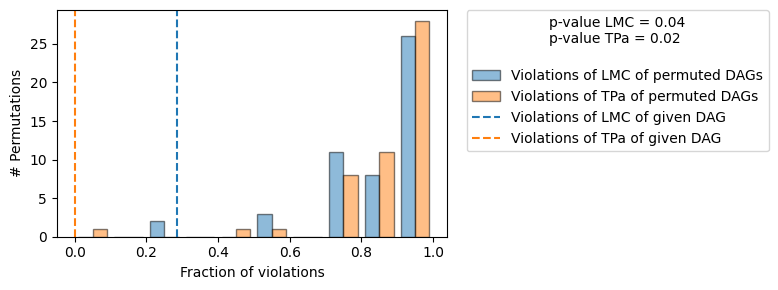

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [28]:
# Create SCM
causal_model = gcm.InvertibleStructuralCausalModel(graph)

causal_model.set_causal_mechanism('demand', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('social reach', gcm.EmpiricalDistribution())

causal_model.set_causal_mechanism('social clicks', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('organic clicks', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('sign ups', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(causal_model, df)

# Check model fit statistics
print(gcm.evaluate_causal_model(causal_model, df))

In [30]:
# Calculate counterfactuals - social impressions
cf_social = gcm.counterfactual_samples(causal_model, {'social reach': lambda x: 0}, observed_data=df)
cf_social = round((df['sign ups'].sum() - cf_social['sign ups'].sum()) / df['sign ups'].sum(), 1)
print(f'social contributed towards {cf_social * 100}% of signups')

social contributed towards 30.0% of signups


In [41]:
# Linear regression
y = df['sign ups'].copy()
X = df[['social reach', 'demand']].copy()
lin_model = LinearRegression()
lin_model = lin_model.fit(X, y)
y_pred = lin_model.predict(X)

# Printing the coefficients
print(f'Intercept: {lin_model.intercept_}')
print(f'Coefficient: {lin_model.coef_}')

Intercept: 0.0
Coefficient: [0.09 0.12]


In [42]:
# Calculate counterfactuals - social reach
cf_social_lin = X.copy()
cf_social_lin['social reach'] = 0
cf_social_lin = lin_model.predict(cf_social_lin)
cf_social_lin = round((y.sum() - cf_social_lin.sum()) / y.sum(), 1)
print(f'social impressions contributed towards {cf_social_lin * 100}% of signups')

social impressions contributed towards 30.0% of signups


In [37]:
# Simulate counterfactuals
df_cf_social = df.copy()
df_cf_social['social reach'] = 0
df_cf_social['social clicks'] = (0.50 * df_cf_social['social reach'])
df_cf_social['organic clicks'] = (0.35 * df_cf_social['demand']) + (0.20 * df_cf_social['social reach'])
df_cf_social['sign ups'] = (0.05 * df_cf_social['demand']) + (0.10 * df_cf_social['social clicks']) + (0.20 * df_cf_social['organic clicks'])

round((df['sign ups'].sum() - df_cf_social['sign ups'].sum()) / df['sign ups'].sum(), 1)

In [ ]:
# Check for multi-collinearity
# Can we check linear regression coefficients
# make some functions for calculating counterfactual contribution
# normalise counterfactual estimates
# enforce coefficient constraints
# carry out intervention